In [7]:
library(readr) # reading csv files
library(dplyr) # handy utility functions
library(tidyr) # data tidying
library(ggplot2) # visualization
library(scales) # visualization
library(lubridate) # working with dates
library(mice) # missing value imputation
library(outliers) # treating outliers
library(fastDummies) # create dummy vars
library(caTools)  # split data
library(car) # vif
library(caret) # train & plot regression models

In [59]:
# reading the given csv files
general_data <- read_csv('general_data.csv')
employee_survey_data <- read_csv('employee_survey_data.csv')
manager_survey_data <- read_csv('manager_survey_data.csv')
in_time <- read_csv('in_time.csv')
out_time <- read_csv('out_time.csv')

Parsed with column specification:
cols(
  .default = col_integer(),
  Attrition = col_character(),
  BusinessTravel = col_character(),
  Department = col_character(),
  EducationField = col_character(),
  Gender = col_character(),
  JobRole = col_character(),
  MaritalStatus = col_character(),
  Over18 = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  EmployeeID = col_integer(),
  EnvironmentSatisfaction = col_integer(),
  JobSatisfaction = col_integer(),
  WorkLifeBalance = col_integer()
)
Parsed with column specification:
cols(
  EmployeeID = col_integer(),
  JobInvolvement = col_integer(),
  PerformanceRating = col_integer()
)
Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  .default = col_datetime(),
  X1 = col_integer(),
  `2015-01-01` = col_character(),
  `2015-01-14` = col_character(),
  `2015-01-26` = col_character(),
  `2015-03-05` = col_character(),
  `2015-05-01` = c

In [60]:
# in_time and out_time files have missing EmployeeID col
names(in_time)[1] <- 'EmployeeID'
names(out_time)[1] <- 'EmployeeID'

In [10]:
# checking for duplicates
general_data %>% duplicated() %>% sum()
employee_survey_data %>% duplicated() %>% sum()
manager_survey_data %>% duplicated() %>% sum()
in_time %>% duplicated() %>% sum()
out_time %>% duplicated() %>% sum()

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

### missing value treatment

In [11]:
# visualizing na values in general_data
missing_by_column <- general_data %>% 
  is.na %>% 
  as_tibble %>% 
  mutate(row_number = 1:nrow(.)) %>% 
  gather(variable, is_missing, -row_number)

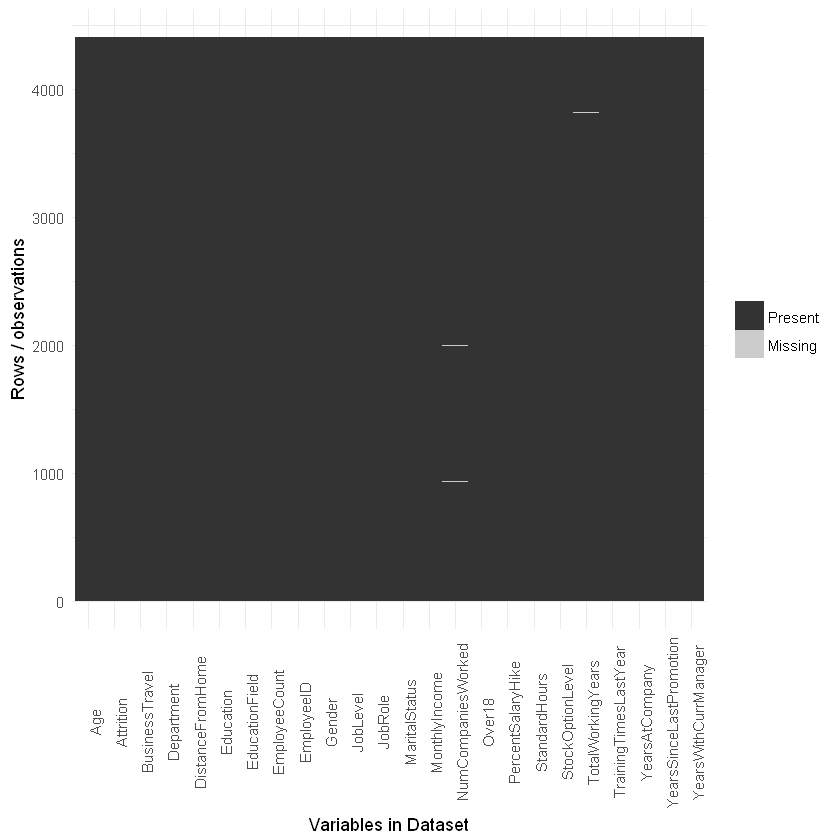

In [12]:
ggplot(missing_by_column, aes(x = variable, y = row_number, fill = is_missing)) +
  geom_tile() + 
  theme_minimal() +
  scale_fill_grey(name = "",
                  labels = c("Present","Missing")) +
  labs(x = "Variables in Dataset",
       y = "Rows / observations") + 
  theme(axis.text.x  = element_text(angle=90))

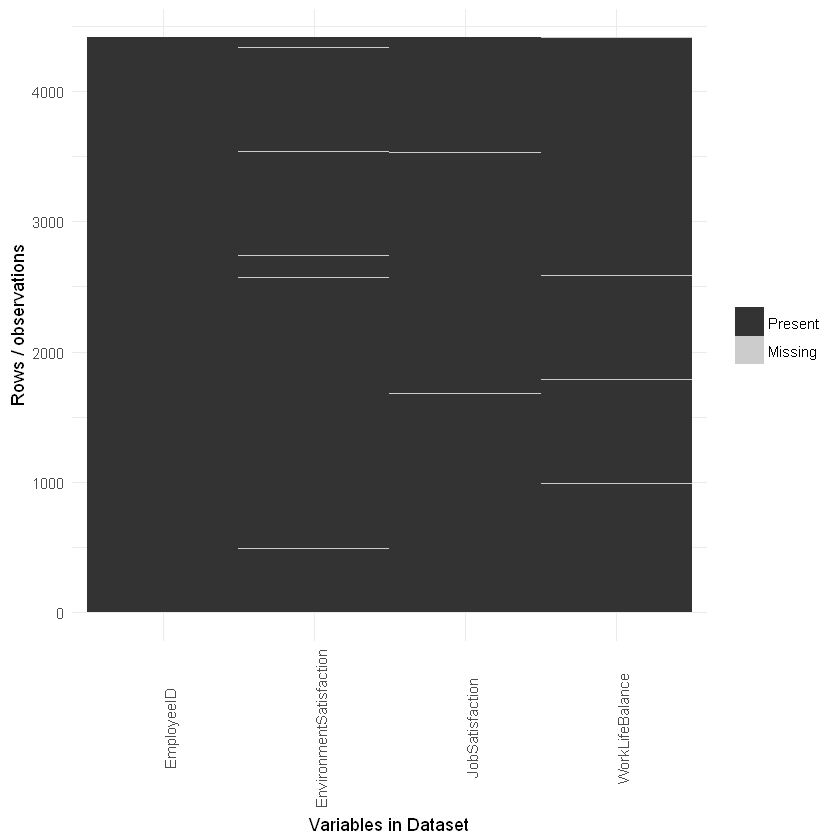

In [13]:
# visualizing na values in employee survey data
missing_by_column <- employee_survey_data %>% 
  is.na %>% 
  as_tibble %>% 
  mutate(row_number = 1:nrow(.)) %>% 
  gather(variable, is_missing, -row_number)

ggplot(missing_by_column, aes(x = variable, y = row_number, fill = is_missing)) +
  geom_tile() + 
  theme_minimal() +
  scale_fill_grey(name = "",
                  labels = c("Present","Missing")) +
  theme(axis.text.x  = element_text(angle=90)) + 
  labs(x = "Variables in Dataset",
       y = "Rows / observations")

In [14]:
# no missing values in manager_survey_data
colSums(sapply(manager_survey_data, FUN = function(c) is.na(c)))

EmployeeID    JobInvolvement PerformanceRating 
                0                 0                 0

In [15]:
# the missing values in in_time and out_time makes sense because these values tell us that the
# either the employee has on leave or its a public holiday

# we dont impute missing data in in_time and out_time bcz data is "missing not at randam"
# but we can impute missing data in general_data and employee_survey_data bcz data is "missing at random"
# we use multiple imputation using MICE pkg

In [61]:
# imputing employee_survey_data
# initialize an empty model to take the parameters from
empty_model <- mice(employee_survey_data, maxit=0) 
method <- empty_model$method
predictorMatrix <- empty_model$predictorMatrix

In [62]:
# first make a bunch of guesses...
employee_imputed_data <- mice(employee_survey_data, method, predictorMatrix, m=5)
# then pick one for each variable
employee_imputed_data <- mice::complete(employee_imputed_data)


 iter imp variable
  1   1  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
  1   2  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
  1   3  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
  1   4  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
  1   5  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
  2   1  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
  2   2  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
  2   3  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
  2   4  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
  2   5  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
  3   1  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
  3   2  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
  3   3  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
  3   4  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
  3   5  EnvironmentSatisfaction  JobSatis

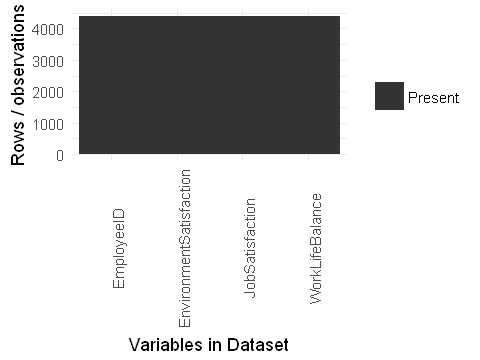

In [63]:
# visualize after imputation to cross check that there are no na values
missing_by_column <- employee_imputed_data %>% 
  is.na %>% 
  as_tibble %>% 
  mutate(row_number = 1:nrow(.)) %>% 
  gather(variable, is_missing, -row_number)

ggplot(missing_by_column, aes(x = variable, y = row_number, fill = is_missing)) +
  geom_tile() + 
  theme_minimal() +
  scale_fill_grey(name = "",
                  labels = c("Present","Missing")) +
  theme(axis.text.x  = element_text(angle=90)) + 
  labs(x = "Variables in Dataset",
       y = "Rows / observations")
employee_survey_data <- employee_imputed_data

In [64]:
# imputing general_data
# initialize an empty model to take the parameters from
empty_model <- mice(general_data, maxit=0) 
method <- empty_model$method
predictorMatrix <- empty_model$predictorMatrix

In [65]:
# first make a bunch of guesses...
general_imputed_data <- mice(general_data, method, predictorMatrix, m=5)
# then pick one for each variable
general_imputed_data <- mice::complete(general_imputed_data)


 iter imp variable
  1   1  NumCompaniesWorked  TotalWorkingYears
  1   2  NumCompaniesWorked  TotalWorkingYears
  1   3  NumCompaniesWorked  TotalWorkingYears
  1   4  NumCompaniesWorked  TotalWorkingYears
  1   5  NumCompaniesWorked  TotalWorkingYears
  2   1  NumCompaniesWorked  TotalWorkingYears
  2   2  NumCompaniesWorked  TotalWorkingYears
  2   3  NumCompaniesWorked  TotalWorkingYears
  2   4  NumCompaniesWorked  TotalWorkingYears
  2   5  NumCompaniesWorked  TotalWorkingYears
  3   1  NumCompaniesWorked  TotalWorkingYears
  3   2  NumCompaniesWorked  TotalWorkingYears
  3   3  NumCompaniesWorked  TotalWorkingYears
  3   4  NumCompaniesWorked  TotalWorkingYears
  3   5  NumCompaniesWorked  TotalWorkingYears
  4   1  NumCompaniesWorked  TotalWorkingYears
  4   2  NumCompaniesWorked  TotalWorkingYears
  4   3  NumCompaniesWorked  TotalWorkingYears
  4   4  NumCompaniesWorked  TotalWorkingYears
  4   5  NumCompaniesWorked  TotalWorkingYears
  5   1  NumCompaniesWorked  TotalWorkin

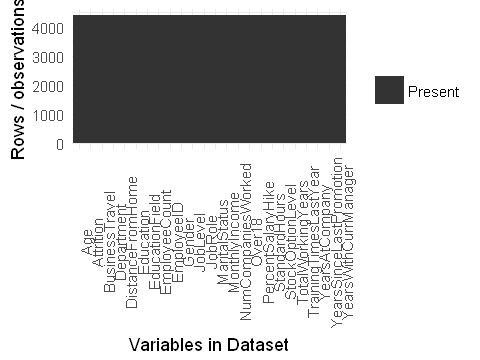

In [66]:
# visualize after imputation to cross check that there are no na values
missing_by_column <- general_imputed_data %>% 
  is.na %>% 
  as_tibble %>% 
  mutate(row_number = 1:nrow(.)) %>% 
  gather(variable, is_missing, -row_number)

ggplot(missing_by_column, aes(x = variable, y = row_number, fill = is_missing)) +
  geom_tile() + 
  theme_minimal() +
  scale_fill_grey(name = "",
                  labels = c("Present","Missing")) +
  theme(axis.text.x  = element_text(angle=90)) + 
  labs(x = "Variables in Dataset",
       y = "Rows / observations")

In [67]:
general_data <- general_imputed_data

In [68]:
# treating outliers
for(i in 2:4){
  print(unique(employee_survey_data[,i]))
} # no outliers in employee survey data


[1] 3 2 4 1
[1] 4 2 1 3
[1] 2 4 1 3


In [24]:
for(i in 2:3){
  print(unique(manager_survey_data[,i]))
} # no outliers in manager survey data


# A tibble: 4 x 1
  JobInvolvement
           <int>
1              3
2              2
3              1
4              4
# A tibble: 2 x 1
  PerformanceRating
              <int>
1                 3
2                 4


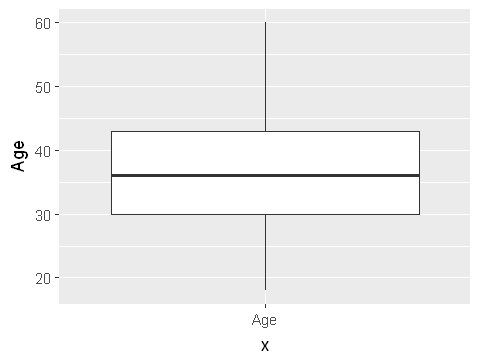

In [27]:
general_data %>% ggplot(aes(x = 'Age', y = Age)) + geom_boxplot() # no outliers

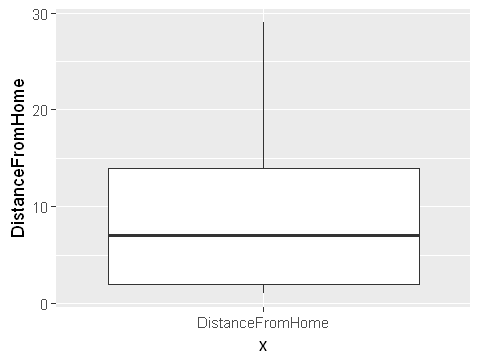

In [28]:
general_data %>% ggplot(aes(x = 'DistanceFromHome', y = DistanceFromHome)) + geom_boxplot() # no outliers

In [29]:
unique(general_data$Education) # no outliers

[1] 2 1 4 5 3

In [30]:
unique(general_data$JobLevel) # no outliers

[1] 1 4 3 2 5

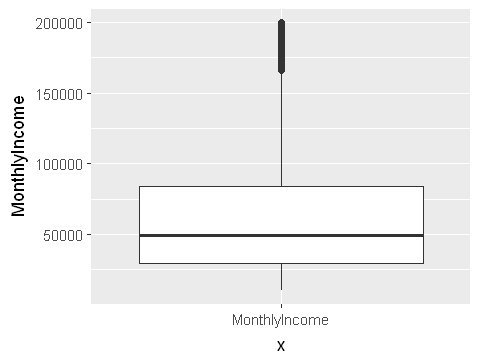

In [31]:
general_data %>% ggplot(aes(x = 'MonthlyIncome', y = MonthlyIncome)) + geom_boxplot() # outliers are present

In [32]:
unique(general_data$NumCompaniesWorked) # no outliers

[1] 1 0 3 4 2 7 9 5 6 8

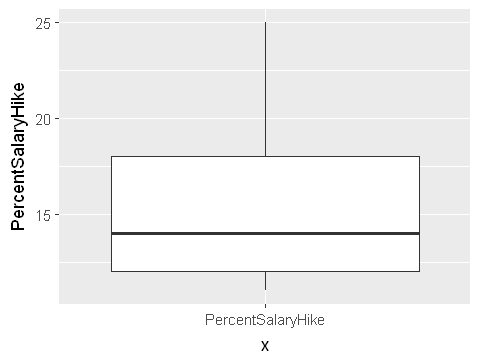

In [33]:
general_data %>% ggplot(aes(x = 'PercentSalaryHike', y = PercentSalaryHike)) + geom_boxplot() # no outliers

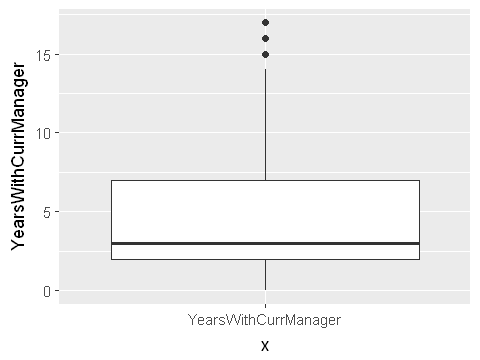

In [34]:
general_data %>% ggplot(aes(x = 'YearsWithCurrManager', y = YearsWithCurrManager)) + geom_boxplot() # outliers are present

In [69]:
# user defined function for dealing with outliers
capOutliers <- function(x, probs = c(.25, .75), caps = c(.05, .95), na.rm = T){
  qnt <- quantile(x, probs = probs, na.rm = na.rm)
  caps <- quantile(x, probs= caps, na.rm = na.rm)
  H <- 1.5 * IQR(x, na.rm = na.rm)
  x[x < (qnt[1] - H)] <- caps[1]
  x[x > (qnt[2] + H)] <- caps[2]
  x
}

In [70]:
general_data$MonthlyIncome <- capOutliers(general_data$MonthlyIncome)
general_data$TotalWorkingYears <- capOutliers(general_data$TotalWorkingYears)
general_data$YearsAtCompany <- capOutliers(general_data$YearsAtCompany)
general_data$YearsSinceLastPromotion <- capOutliers(general_data$YearsSinceLastPromotion)
general_data$YearsWithCurrManager <- capOutliers(general_data$YearsWithCurrManager)

### pre-processing the data for visualizations and model building

In [71]:
employee_survey_data[,-1] <- employee_survey_data[,-1] %>% mutate_all(~factor(.x, levels = c(1,2,3,4), ordered = T))
manager_survey_data[,-1] <- manager_survey_data[,-1] %>% mutate_all(~factor(.x, levels = c(1,2,3,4), ordered = T))

factor_var_generaldata <- c('Attrition', 'BusinessTravel', 'Department', 'EducationField', 
                           'Gender', 'JobRole', 'MaritalStatus', 'StockOptionLevel')
ord_var_generaldata <- c('Education', 'JobLevel', 'NumCompaniesWorked', 'TrainingTimesLastYear')

general_data[factor_var_generaldata] <- lapply(general_data[factor_var_generaldata], FUN = function(c) as.factor(c))
general_data[ord_var_generaldata] <- lapply(general_data[ord_var_generaldata], FUN = function(c) factor(c, ordered = T))
general_data$EmployeeCount <- NULL
general_data$Over18 <- NULL
general_data$StandardHours <- NULL

In [72]:
data <- inner_join(general_data, employee_survey_data, by = 'EmployeeID')
data <- inner_join(data, manager_survey_data, by = 'EmployeeID')
data <- data %>% select(EmployeeID, everything())

In [73]:
#  derived metrics from in_time and out_time 
in_time[,2:ncol(in_time)] <- sapply(in_time[,2:ncol(in_time)], 
                                    FUN = function(c) strftime(c, format = '%H:%M:%S', tz = 'GMT'))

In [74]:
out_time[,2:ncol(out_time)] <- sapply(out_time[,2:ncol(out_time)], 
                                    FUN = function(c) strftime(c, format = '%H:%M:%S', tz = 'GMT'))

In [75]:
in_time[,2:ncol(in_time)] <- in_time %>% select(-EmployeeID) %>% mutate_all(hms)
out_time[,2:ncol(out_time)] <- out_time %>% select(-EmployeeID) %>% mutate_all(hms)

Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order

"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all st

"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all st

"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all st

"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all st

"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all st

"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all st

"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"Warning message in .parse_hms(..., order = "HMS", quiet = quiet):
"Some strings failed to parse, or all st

In [77]:
# find the avg in_time for every employee
in_time$avg_inTime <- in_time %>% select(-EmployeeID) %>% mutate_all(period_to_seconds) %>% 
  apply(MARGIN = 1, FUN = function(r) mean(r, na.rm = T)) %>% seconds_to_period()

out_time$avg_outTime <- out_time %>% select(-EmployeeID) %>% mutate_all(period_to_seconds) %>% 
  apply(MARGIN = 1, FUN = function(r) mean(r, na.rm = T)) %>% seconds_to_period()

ave_time_in_office <- seconds_to_period(period_to_seconds(out_time$avg_outTime) - 
                                          period_to_seconds(in_time$avg_inTime))

In [78]:
# number of public holidays is 12
num_of_pulic_holidays <- 0
for(i in 2:ncol(in_time)){
  if(all(is.na(in_time[,i]))){
    num_of_pulic_holidays <- num_of_pulic_holidays + 1
  }
}

In [79]:
# number of holidays taken by employees
num_of_holidays_taken <- apply(in_time, 1, FUN = function(r) sum(is.na(r))) - num_of_pulic_holidays

data$NumOfHolidaysTaken <- num_of_holidays_taken
data$DailyAverageTime <- strptime(Sys.Date(), "%Y-%m-%d", tz="GMT") + 
  period_to_seconds(ave_time_in_office)

###   Univariate and Bivariate analysis

In [43]:
# there is approximately 15% Attrition
table(data$Attrition)


  No  Yes 
3699  711 

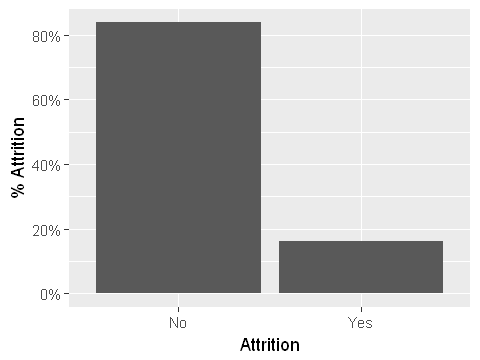

In [44]:
data %>% ggplot(aes(x = Attrition)) + geom_bar(aes(y = (..count..)/sum(..count..))) + 
  scale_y_continuous(labels = percent) + labs(y = '% Attrition')

In [45]:
# hr are leaving more
table(data$Attrition, data$Department)

     
      Human Resources Research & Development Sales
  No              132                   2430  1137
  Yes              57                    453   201

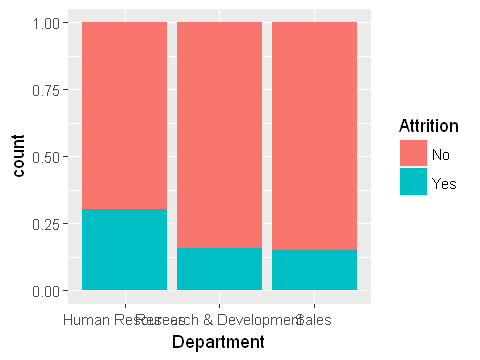

In [46]:
ggplot(data, aes(x = Department, fill = Attrition)) + geom_bar(position = 'fill')

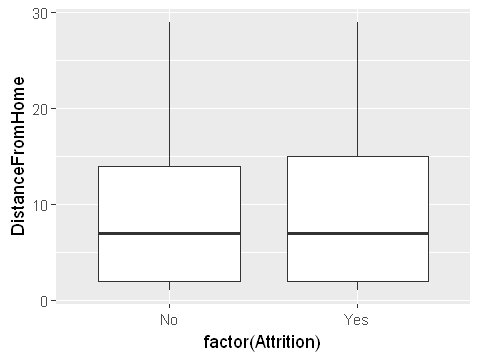

In [47]:
# upper bound distance is high for ppl who are leaving
ggplot(data, aes(x = factor(Attrition), y = DistanceFromHome)) + geom_boxplot()

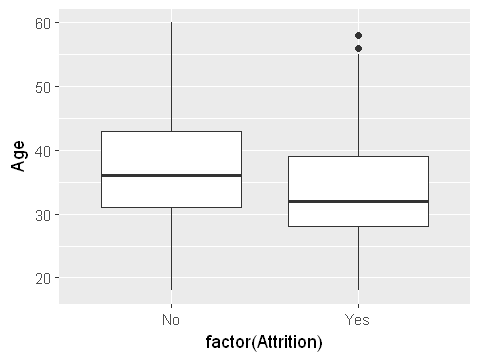

In [48]:
# younger people are likely to leave the company
ggplot(data, aes(x = factor(Attrition), y = Age)) + geom_boxplot()

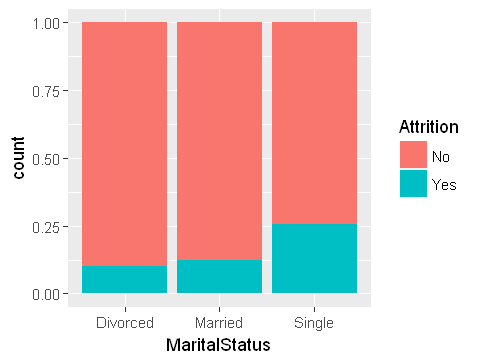

In [49]:
# no wonder single is more likely to levae
ggplot(data, aes(x = MaritalStatus, fill = Attrition)) + geom_bar(position = 'fill')

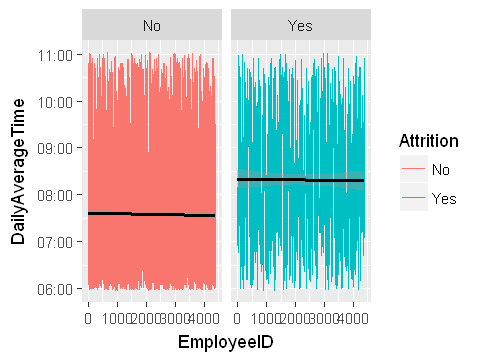

In [50]:
# daily average time is higher for people who leave the company
data %>% ggplot(aes(x = EmployeeID, y = DailyAverageTime, col = Attrition)) + geom_line() + 
  geom_smooth(method = 'gam', col = 'black') + facet_wrap(~Attrition)

In [80]:
# creating dummies for fct vars
data$Attrition <- if_else(data$Attrition == "Yes", 1, 0)
data$Gender <- if_else(data$Gender == 'Male', 1, 0)

In [81]:
data <- data %>% dplyr::select(EmployeeID, Attrition, Gender, Age, DistanceFromHome, MonthlyIncome, 
                               PercentSalaryHike, TotalWorkingYears, YearsAtCompany, YearsSinceLastPromotion, 
                               YearsWithCurrManager, NumOfHolidaysTaken, DailyAverageTime, everything())

dummies <- dummy_cols(data, remove_first_dummy = T, select_columns = names(data)[14:28])
dummies <- dummies[,29:ncol(dummies)]
data <- bind_cols(data[,-(14:28)], dummies)
data$EmployeeID <- NULL

In [82]:
# Normalising continuous features

data$Age <- scale(data$Age)
data$DistanceFromHome <- scale(data$DistanceFromHome)
data$MonthlyIncome <- scale(data$MonthlyIncome)
data$PercentSalaryHike <- scale(data$PercentSalaryHike)
data$TotalWorkingYears <- scale(data$TotalWorkingYears)
data$YearsAtCompany <- scale(data$YearsAtCompany)
data$YearsSinceLastPromotion <- scale(data$YearsSinceLastPromotion)
data$YearsWithCurrManager <- scale(data$YearsWithCurrManager)
data$NumOfHolidaysTaken <- scale(data$NumOfHolidaysTaken)

In [83]:
# splitting the data between train and test

set.seed(123)
mask <- sample.split(data$Attrition, SplitRatio = 0.7)
train_df <- data[mask,]
test_df <- data[!mask,]

# Logistic Regression

In [84]:
#Initial model
model_1 <- glm(Attrition ~ ., data = train_df, family = "binomial")
summary(model_1)


Call:
glm(formula = Attrition ~ ., family = "binomial", data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7575  -0.5599  -0.3189  -0.1532   3.8587  

Coefficients:
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      -2.253e+05  1.843e+04 -12.222  < 2e-16 ***
Gender                            6.523e-02  1.187e-01   0.549 0.582728    
Age                              -2.576e-01  8.128e-02  -3.170 0.001526 ** 
DistanceFromHome                 -4.057e-02  5.882e-02  -0.690 0.490426    
MonthlyIncome                    -6.349e-02  6.068e-02  -1.046 0.295419    
PercentSalaryHike                 5.161e-02  9.116e-02   0.566 0.571308    
TotalWorkingYears                -5.866e-01  1.282e-01  -4.576 4.75e-06 ***
YearsAtCompany                   -8.679e-03  1.513e-01  -0.057 0.954260    
YearsSinceLastPromotion           5.431e-01  8.179e-02   6.641 3.12e-11 ***
YearsWithCurrManager             -5.0

In [56]:
# Stepwise selection
step <- MASS::stepAIC(model_1, direction = 'both')
step

Start:  AIC=2162.3
Attrition ~ Gender + Age + DistanceFromHome + MonthlyIncome + 
    PercentSalaryHike + TotalWorkingYears + YearsAtCompany + 
    YearsSinceLastPromotion + YearsWithCurrManager + NumOfHolidaysTaken + 
    DailyAverageTime + JobLevel_2 + JobLevel_5 + `JobRole_Research Scientist` + 
    `JobRole_Sales Executive` + `JobRole_Human Resources` + `JobRole_Research Director` + 
    `JobRole_Laboratory Technician` + `JobRole_Manufacturing Director` + 
    `JobRole_Sales Representative` + JobRole_Manager + MaritalStatus_Single + 
    MaritalStatus_Divorced + NumCompaniesWorked_0 + NumCompaniesWorked_3 + 
    NumCompaniesWorked_4 + NumCompaniesWorked_2 + NumCompaniesWorked_7 + 
    NumCompaniesWorked_9 + NumCompaniesWorked_5 + NumCompaniesWorked_6 + 
    NumCompaniesWorked_8 + StockOptionLevel_1 + StockOptionLevel_3 + 
    StockOptionLevel_2 + TrainingTimesLastYear_3 + TrainingTimesLastYear_2 + 
    TrainingTimesLastYear_5 + TrainingTimesLastYear_4 + TrainingTimesLastYear_0 + 
 


Step:  AIC=2158.31
Attrition ~ Gender + Age + DistanceFromHome + MonthlyIncome + 
    PercentSalaryHike + TotalWorkingYears + YearsSinceLastPromotion + 
    YearsWithCurrManager + NumOfHolidaysTaken + DailyAverageTime + 
    JobLevel_2 + JobLevel_5 + `JobRole_Research Scientist` + 
    `JobRole_Sales Executive` + `JobRole_Human Resources` + `JobRole_Research Director` + 
    `JobRole_Laboratory Technician` + `JobRole_Manufacturing Director` + 
    `JobRole_Sales Representative` + JobRole_Manager + MaritalStatus_Single + 
    MaritalStatus_Divorced + NumCompaniesWorked_0 + NumCompaniesWorked_3 + 
    NumCompaniesWorked_4 + NumCompaniesWorked_2 + NumCompaniesWorked_7 + 
    NumCompaniesWorked_9 + NumCompaniesWorked_5 + NumCompaniesWorked_6 + 
    NumCompaniesWorked_8 + StockOptionLevel_1 + StockOptionLevel_3 + 
    StockOptionLevel_2 + TrainingTimesLastYear_3 + TrainingTimesLastYear_2 + 
    TrainingTimesLastYear_5 + TrainingTimesLastYear_4 + TrainingTimesLastYear_0 + 
    TrainingTimes


Step:  AIC=2154.35
Attrition ~ Gender + Age + DistanceFromHome + MonthlyIncome + 
    PercentSalaryHike + TotalWorkingYears + YearsSinceLastPromotion + 
    YearsWithCurrManager + DailyAverageTime + JobLevel_2 + JobLevel_5 + 
    `JobRole_Research Scientist` + `JobRole_Sales Executive` + 
    `JobRole_Human Resources` + `JobRole_Research Director` + 
    `JobRole_Laboratory Technician` + `JobRole_Manufacturing Director` + 
    `JobRole_Sales Representative` + JobRole_Manager + MaritalStatus_Single + 
    MaritalStatus_Divorced + NumCompaniesWorked_0 + NumCompaniesWorked_3 + 
    NumCompaniesWorked_4 + NumCompaniesWorked_7 + NumCompaniesWorked_9 + 
    NumCompaniesWorked_5 + NumCompaniesWorked_6 + NumCompaniesWorked_8 + 
    StockOptionLevel_1 + StockOptionLevel_3 + StockOptionLevel_2 + 
    TrainingTimesLastYear_3 + TrainingTimesLastYear_2 + TrainingTimesLastYear_5 + 
    TrainingTimesLastYear_4 + TrainingTimesLastYear_0 + TrainingTimesLastYear_1 + 
    EnvironmentSatisfaction_2 + Env


Step:  AIC=2150.55
Attrition ~ Gender + Age + DistanceFromHome + MonthlyIncome + 
    PercentSalaryHike + TotalWorkingYears + YearsSinceLastPromotion + 
    YearsWithCurrManager + DailyAverageTime + JobLevel_2 + JobLevel_5 + 
    `JobRole_Research Scientist` + `JobRole_Sales Executive` + 
    `JobRole_Human Resources` + `JobRole_Research Director` + 
    `JobRole_Laboratory Technician` + `JobRole_Manufacturing Director` + 
    MaritalStatus_Single + MaritalStatus_Divorced + NumCompaniesWorked_0 + 
    NumCompaniesWorked_3 + NumCompaniesWorked_4 + NumCompaniesWorked_7 + 
    NumCompaniesWorked_9 + NumCompaniesWorked_5 + NumCompaniesWorked_6 + 
    NumCompaniesWorked_8 + StockOptionLevel_1 + StockOptionLevel_3 + 
    StockOptionLevel_2 + TrainingTimesLastYear_3 + TrainingTimesLastYear_2 + 
    TrainingTimesLastYear_5 + TrainingTimesLastYear_4 + TrainingTimesLastYear_0 + 
    TrainingTimesLastYear_1 + EnvironmentSatisfaction_2 + EnvironmentSatisfaction_4 + 
    EnvironmentSatisfaction_1 


Step:  AIC=2146.91
Attrition ~ Gender + Age + DistanceFromHome + MonthlyIncome + 
    PercentSalaryHike + TotalWorkingYears + YearsSinceLastPromotion + 
    YearsWithCurrManager + DailyAverageTime + JobLevel_2 + JobLevel_5 + 
    `JobRole_Research Scientist` + `JobRole_Sales Executive` + 
    `JobRole_Human Resources` + `JobRole_Research Director` + 
    `JobRole_Laboratory Technician` + `JobRole_Manufacturing Director` + 
    MaritalStatus_Single + MaritalStatus_Divorced + NumCompaniesWorked_0 + 
    NumCompaniesWorked_3 + NumCompaniesWorked_4 + NumCompaniesWorked_7 + 
    NumCompaniesWorked_9 + NumCompaniesWorked_5 + NumCompaniesWorked_6 + 
    NumCompaniesWorked_8 + StockOptionLevel_1 + StockOptionLevel_3 + 
    TrainingTimesLastYear_3 + TrainingTimesLastYear_2 + TrainingTimesLastYear_5 + 
    TrainingTimesLastYear_4 + TrainingTimesLastYear_0 + TrainingTimesLastYear_1 + 
    EnvironmentSatisfaction_4 + EnvironmentSatisfaction_1 + JobSatisfaction_2 + 
    JobSatisfaction_1 + JobSati


Step:  AIC=2143.6
Attrition ~ Age + DistanceFromHome + MonthlyIncome + PercentSalaryHike + 
    TotalWorkingYears + YearsSinceLastPromotion + YearsWithCurrManager + 
    DailyAverageTime + JobLevel_2 + JobLevel_5 + `JobRole_Research Scientist` + 
    `JobRole_Sales Executive` + `JobRole_Research Director` + 
    `JobRole_Laboratory Technician` + `JobRole_Manufacturing Director` + 
    MaritalStatus_Single + MaritalStatus_Divorced + NumCompaniesWorked_0 + 
    NumCompaniesWorked_3 + NumCompaniesWorked_4 + NumCompaniesWorked_7 + 
    NumCompaniesWorked_9 + NumCompaniesWorked_5 + NumCompaniesWorked_6 + 
    NumCompaniesWorked_8 + StockOptionLevel_1 + StockOptionLevel_3 + 
    TrainingTimesLastYear_3 + TrainingTimesLastYear_2 + TrainingTimesLastYear_5 + 
    TrainingTimesLastYear_4 + TrainingTimesLastYear_0 + TrainingTimesLastYear_1 + 
    EnvironmentSatisfaction_4 + EnvironmentSatisfaction_1 + JobSatisfaction_2 + 
    JobSatisfaction_1 + JobSatisfaction_3 + WorkLifeBalance_4 + 
    WorkL


Step:  AIC=2140.48
Attrition ~ Age + DistanceFromHome + MonthlyIncome + PercentSalaryHike + 
    TotalWorkingYears + YearsSinceLastPromotion + YearsWithCurrManager + 
    DailyAverageTime + JobLevel_2 + JobLevel_5 + `JobRole_Research Scientist` + 
    `JobRole_Sales Executive` + `JobRole_Research Director` + 
    `JobRole_Laboratory Technician` + `JobRole_Manufacturing Director` + 
    MaritalStatus_Single + MaritalStatus_Divorced + NumCompaniesWorked_0 + 
    NumCompaniesWorked_3 + NumCompaniesWorked_4 + NumCompaniesWorked_7 + 
    NumCompaniesWorked_9 + NumCompaniesWorked_5 + NumCompaniesWorked_6 + 
    StockOptionLevel_1 + TrainingTimesLastYear_3 + TrainingTimesLastYear_2 + 
    TrainingTimesLastYear_5 + TrainingTimesLastYear_4 + TrainingTimesLastYear_0 + 
    TrainingTimesLastYear_1 + EnvironmentSatisfaction_4 + EnvironmentSatisfaction_1 + 
    JobSatisfaction_2 + JobSatisfaction_1 + JobSatisfaction_3 + 
    WorkLifeBalance_4 + WorkLifeBalance_1 + WorkLifeBalance_3 + 
    JobInvol

                                   Df Deviance    AIC
- DistanceFromHome                  1   2056.2 2136.2
- JobInvolvement_4                  1   2056.3 2136.3
- JobInvolvement_2                  1   2056.5 2136.5
- NumCompaniesWorked_4              1   2056.6 2136.6
- MonthlyIncome                     1   2056.6 2136.6
- PercentSalaryHike                 1   2056.6 2136.6
- `JobRole_Manufacturing Director`  1   2056.7 2136.7
- StockOptionLevel_1                1   2056.9 2136.9
- MaritalStatus_Divorced            1   2057.1 2137.1
- NumCompaniesWorked_3              1   2057.2 2137.2
<none>                                  2055.6 2137.6
- JobInvolvement_1                  1   2058.4 2138.4
+ EnvironmentSatisfaction_4         1   2055.0 2139.0
- NumCompaniesWorked_6              1   2059.1 2139.1
+ StockOptionLevel_3                1   2055.1 2139.1
+ EnvironmentSatisfaction_2         1   2055.1 2139.1
+ WorkLifeBalance_4                 1   2055.1 2139.1
+ NumCompaniesWorked_8      


Step:  AIC=2133.44
Attrition ~ Age + MonthlyIncome + PercentSalaryHike + TotalWorkingYears + 
    YearsSinceLastPromotion + YearsWithCurrManager + DailyAverageTime + 
    JobLevel_2 + JobLevel_5 + `JobRole_Research Scientist` + 
    `JobRole_Sales Executive` + `JobRole_Research Director` + 
    `JobRole_Laboratory Technician` + `JobRole_Manufacturing Director` + 
    MaritalStatus_Single + MaritalStatus_Divorced + NumCompaniesWorked_0 + 
    NumCompaniesWorked_3 + NumCompaniesWorked_4 + NumCompaniesWorked_7 + 
    NumCompaniesWorked_9 + NumCompaniesWorked_5 + NumCompaniesWorked_6 + 
    StockOptionLevel_1 + TrainingTimesLastYear_3 + TrainingTimesLastYear_2 + 
    TrainingTimesLastYear_5 + TrainingTimesLastYear_4 + TrainingTimesLastYear_0 + 
    TrainingTimesLastYear_1 + EnvironmentSatisfaction_1 + JobSatisfaction_2 + 
    JobSatisfaction_1 + JobSatisfaction_3 + WorkLifeBalance_1 + 
    WorkLifeBalance_3 + JobInvolvement_1

                                   Df Deviance    AIC
- NumCom

                                   Df Deviance    AIC
- `JobRole_Manufacturing Director`  1   2060.6 2130.6
- StockOptionLevel_1                1   2060.6 2130.6
- MonthlyIncome                     1   2060.6 2130.6
- MaritalStatus_Divorced            1   2060.7 2130.7
<none>                                  2059.2 2131.2
- JobInvolvement_1                  1   2061.4 2131.4
- NumCompaniesWorked_3              1   2061.5 2131.5
- NumCompaniesWorked_6              1   2062.2 2132.2
+ PercentSalaryHike                 1   2058.4 2132.4
+ NumCompaniesWorked_4              1   2058.4 2132.4
+ EnvironmentSatisfaction_4         1   2058.4 2132.4
+ EnvironmentSatisfaction_2         1   2058.6 2132.6
+ PerformanceRating_4               1   2058.7 2132.7
+ JobInvolvement_2                  1   2058.7 2132.7
+ WorkLifeBalance_4                 1   2058.7 2132.7
+ DistanceFromHome                  1   2058.8 2132.8
+ `JobRole_Human Resources`         1   2058.8 2132.8
+ JobInvolvement_4          


Step:  AIC=2129.3
Attrition ~ Age + MonthlyIncome + TotalWorkingYears + YearsSinceLastPromotion + 
    YearsWithCurrManager + DailyAverageTime + JobLevel_2 + JobLevel_5 + 
    `JobRole_Research Scientist` + `JobRole_Sales Executive` + 
    `JobRole_Research Director` + `JobRole_Laboratory Technician` + 
    MaritalStatus_Single + NumCompaniesWorked_0 + NumCompaniesWorked_3 + 
    NumCompaniesWorked_7 + NumCompaniesWorked_9 + NumCompaniesWorked_5 + 
    NumCompaniesWorked_6 + TrainingTimesLastYear_3 + TrainingTimesLastYear_2 + 
    TrainingTimesLastYear_5 + TrainingTimesLastYear_4 + TrainingTimesLastYear_0 + 
    TrainingTimesLastYear_1 + EnvironmentSatisfaction_1 + JobSatisfaction_2 + 
    JobSatisfaction_1 + JobSatisfaction_3 + WorkLifeBalance_1 + 
    WorkLifeBalance_3 + JobInvolvement_1

                                   Df Deviance    AIC
- MonthlyIncome                     1   2065.0 2129.0
<none>                                  2063.3 2129.3
- NumCompaniesWorked_3             


Call:  glm(formula = Attrition ~ Age + TotalWorkingYears + YearsSinceLastPromotion + 
    YearsWithCurrManager + DailyAverageTime + JobLevel_2 + JobLevel_5 + 
    `JobRole_Research Scientist` + `JobRole_Sales Executive` + 
    `JobRole_Research Director` + `JobRole_Laboratory Technician` + 
    MaritalStatus_Single + NumCompaniesWorked_0 + NumCompaniesWorked_3 + 
    NumCompaniesWorked_7 + NumCompaniesWorked_9 + NumCompaniesWorked_5 + 
    NumCompaniesWorked_6 + TrainingTimesLastYear_3 + TrainingTimesLastYear_2 + 
    TrainingTimesLastYear_5 + TrainingTimesLastYear_4 + TrainingTimesLastYear_0 + 
    TrainingTimesLastYear_1 + EnvironmentSatisfaction_1 + JobSatisfaction_2 + 
    JobSatisfaction_1 + JobSatisfaction_3 + WorkLifeBalance_1 + 
    WorkLifeBalance_3 + JobInvolvement_1, family = "binomial", 
    data = train_df)

Coefficients:
                    (Intercept)                              Age  
                     -2.246e+05                       -2.437e-01  
              Tota

In [85]:
model_2 <- glm(formula = Attrition ~ Age + TotalWorkingYears + YearsSinceLastPromotion + 
    YearsWithCurrManager + DailyAverageTime + JobLevel_2 + JobLevel_5 + 
    `JobRole_Research Scientist` + `JobRole_Sales Executive` + 
    `JobRole_Research Director` + `JobRole_Laboratory Technician` + 
    MaritalStatus_Single + NumCompaniesWorked_0 + NumCompaniesWorked_3 + 
    NumCompaniesWorked_7 + NumCompaniesWorked_9 + NumCompaniesWorked_5 + 
    NumCompaniesWorked_6 + TrainingTimesLastYear_3 + TrainingTimesLastYear_2 + 
    TrainingTimesLastYear_5 + TrainingTimesLastYear_4 + TrainingTimesLastYear_0 + 
    TrainingTimesLastYear_1 + EnvironmentSatisfaction_1 + JobSatisfaction_2 + 
    JobSatisfaction_1 + JobSatisfaction_3 + WorkLifeBalance_1 + 
    WorkLifeBalance_3 + JobInvolvement_1, family = "binomial", 
    data = train_df)
summary(model_2)


Call:
glm(formula = Attrition ~ Age + TotalWorkingYears + YearsSinceLastPromotion + 
    YearsWithCurrManager + DailyAverageTime + JobLevel_2 + JobLevel_5 + 
    `JobRole_Research Scientist` + `JobRole_Sales Executive` + 
    `JobRole_Research Director` + `JobRole_Laboratory Technician` + 
    MaritalStatus_Single + NumCompaniesWorked_0 + NumCompaniesWorked_3 + 
    NumCompaniesWorked_7 + NumCompaniesWorked_9 + NumCompaniesWorked_5 + 
    NumCompaniesWorked_6 + TrainingTimesLastYear_3 + TrainingTimesLastYear_2 + 
    TrainingTimesLastYear_5 + TrainingTimesLastYear_4 + TrainingTimesLastYear_0 + 
    TrainingTimesLastYear_1 + EnvironmentSatisfaction_1 + JobSatisfaction_2 + 
    JobSatisfaction_1 + JobSatisfaction_3 + WorkLifeBalance_1 + 
    WorkLifeBalance_3 + JobInvolvement_1, family = "binomial", 
    data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7237  -0.5587  -0.3257  -0.1626   3.8963  

Coefficients:
                                  Estim

In [86]:
# Removing multicollinearity through VIF check
vif(model_2)

Age               TotalWorkingYears 
                       1.717774                        2.297850 
        YearsSinceLastPromotion            YearsWithCurrManager 
                       1.744295                        1.864995 
               DailyAverageTime                      JobLevel_2 
                       1.121504                        1.070692 
                     JobLevel_5    `JobRole_Research Scientist` 
                       1.076728                        1.396740 
      `JobRole_Sales Executive`     `JobRole_Research Director` 
                       1.461908                        1.202064 
`JobRole_Laboratory Technician`            MaritalStatus_Single 
                       1.378067                        1.067600 
           NumCompaniesWorked_0            NumCompaniesWorked_3 
                       1.097147                        1.149871 
           NumCompaniesWorked_7            NumCompaniesWorked_9 
                       1.133597                        1.091670 
           NumCompaniesWorked_5            NumCompaniesWorked_6 
                       1.097205                        1.090596 
        TrainingTimesLastYear_3         TrainingTimesLastYear_2 
                       9.674195                        9.825184 
        TrainingTimesLastYear_5         TrainingTimesLastYear_4 
                       3.992479                        3.783564 
        TrainingTimesLastYear_0         TrainingTimesLastYear_1 
                       2.263993                        2.844372 
      EnvironmentSatisfaction_1               JobSatisfaction_2 
                       1.065904                        1.550890 
              JobSatisfaction_1               JobSatisfaction_3 
                       1.663601                        1.689444 
              WorkLifeBalance_1               WorkLifeBalance_3 
                       1.192953                        1.179365 
               JobInvolvement_1 
                       1.038669

In [89]:
# continuing with removing variables having high vif and those that are not significant we get a final model
model_18 <- glm(formula = Attrition ~ Age + TotalWorkingYears + YearsSinceLastPromotion + 
                  YearsWithCurrManager + DailyAverageTime +  
                  `JobRole_Research Scientist` + `JobRole_Sales Executive` + 
                  `JobRole_Research Director` + `JobRole_Laboratory Technician` + 
                  MaritalStatus_Single + 
                  NumCompaniesWorked_0 + NumCompaniesWorked_7 + 
                  NumCompaniesWorked_9 + NumCompaniesWorked_5 +  
                  EnvironmentSatisfaction_1 + JobSatisfaction_2 + JobSatisfaction_1 + 
                  JobSatisfaction_3 + WorkLifeBalance_1, family = "binomial", data = train_df)
summary(model_18)


Call:
glm(formula = Attrition ~ Age + TotalWorkingYears + YearsSinceLastPromotion + 
    YearsWithCurrManager + DailyAverageTime + `JobRole_Research Scientist` + 
    `JobRole_Sales Executive` + `JobRole_Research Director` + 
    `JobRole_Laboratory Technician` + MaritalStatus_Single + 
    NumCompaniesWorked_0 + NumCompaniesWorked_7 + NumCompaniesWorked_9 + 
    NumCompaniesWorked_5 + EnvironmentSatisfaction_1 + JobSatisfaction_2 + 
    JobSatisfaction_1 + JobSatisfaction_3 + WorkLifeBalance_1, 
    family = "binomial", data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6423  -0.5665  -0.3425  -0.1804   3.9102  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -2.190e+05  1.716e+04 -12.760  < 2e-16 ***
Age                             -2.594e-01  7.514e-02  -3.452 0.000557 ***
TotalWorkingYears               -5.653e-01  1.014e-01  -5.573 2.51e-08 ***
YearsSinceLastPromotion   

In [90]:
final_model <- model_18

### Model Evaluation

In [91]:
#predicted probabilities of Attrition for test data

test_pred = predict(final_model, type = "response", 
                    newdata = test_df[,-1])
summary(test_pred)
test_df$prob <- test_pred

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0004801 0.0375312 0.0957086 0.1573742 0.2130086 0.9166766 

In [92]:
# Let's use the probability cutoff of 50%.
test_pred_attrition <- factor(if_else(test_df$prob >= 0.50, "Yes", "No"))
test_actual_attrition <- factor(if_else(test_df$Attrition == 1,"Yes","No"))
confusionMatrix(test_pred_attrition, test_actual_attrition, positive = "Yes")

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1088  165
       Yes   22   48
                                         
               Accuracy : 0.8587         
                 95% CI : (0.8387, 0.877)
    No Information Rate : 0.839          
    P-Value [Acc > NIR] : 0.02672        
                                         
                  Kappa : 0.282          
 Mcnemar's Test P-Value : < 2e-16        
                                         
            Sensitivity : 0.22535        
            Specificity : 0.98018        
         Pos Pred Value : 0.68571        
         Neg Pred Value : 0.86832        
             Prevalence : 0.16100        
         Detection Rate : 0.03628        
   Detection Prevalence : 0.05291        
      Balanced Accuracy : 0.60277        
                                         
       'Positive' Class : Yes            
                                         

In [93]:
# Let's Choose the cutoff value. 
# Let's find out the optimal probalility cutoff 

perform_fn <- function(cutoff) 
{
  predicted_attrition <- factor(ifelse(test_pred >= cutoff, "Yes", "No"))
  conf <- confusionMatrix(predicted_attrition, test_actual_attrition, positive = "Yes")
  acc <- conf$overall[1]
  sens <- conf$byClass[1]
  spec <- conf$byClass[2]
  out <- t(as.matrix(c(sens, spec, acc))) 
  colnames(out) <- c("sensitivity", "specificity", "accuracy")
  return(out)
}

In [94]:
summary(test_pred)
s = seq(.001,.96,length=100)
OUT = matrix(0,100,3)

for(i in 1:100)
{
  OUT[i,] = perform_fn(s[i])
} 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0004801 0.0375312 0.0957086 0.1573742 0.2130086 0.9166766 

Warning message in confusionMatrix.default(predicted_attrition, test_actual_attrition, :
"Levels are not in the same order for reference and data. Refactoring data to match."Warning message in confusionMatrix.default(predicted_attrition, test_actual_attrition, :
"Levels are not in the same order for reference and data. Refactoring data to match."Warning message in confusionMatrix.default(predicted_attrition, test_actual_attrition, :
"Levels are not in the same order for reference and data. Refactoring data to match."Warning message in confusionMatrix.default(predicted_attrition, test_actual_attrition, :
"Levels are not in the same order for reference and data. Refactoring data to match."Warning message in confusionMatrix.default(predicted_attrition, test_actual_attrition, :
"Levels are not in the same order for reference and data. Refactoring data to match."

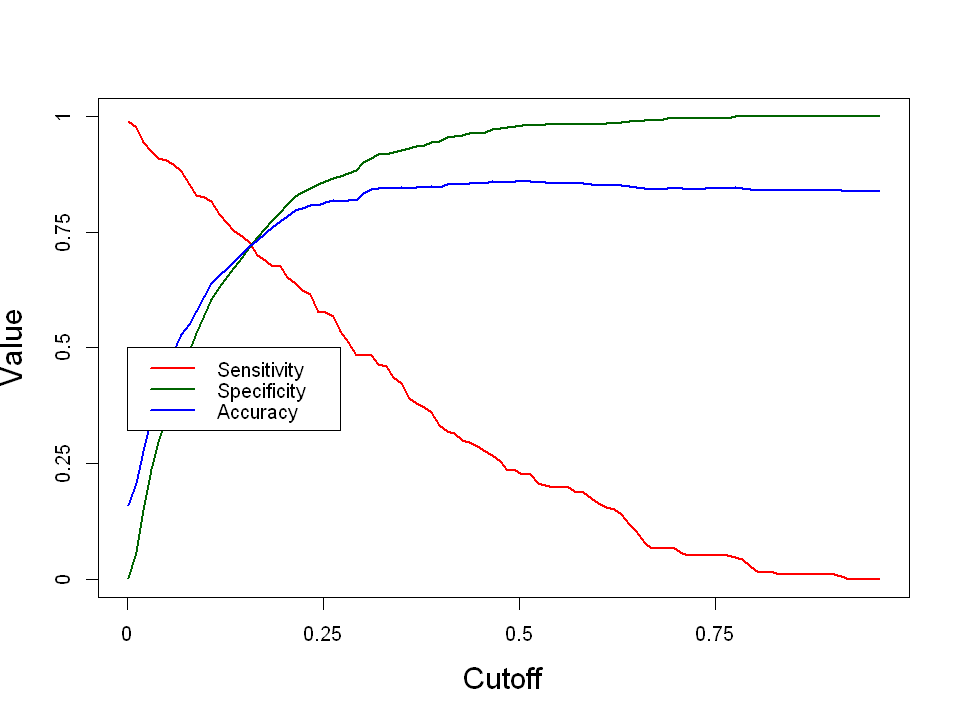

In [97]:
plot(s, OUT[,1],xlab="Cutoff",ylab="Value",cex.lab=1.5,cex.axis=1.5,ylim=c(0,1),type="l",lwd=2,axes=FALSE,col=2)
axis(1,seq(0,1,length=5),seq(0,1,length=5),cex.lab=1.5)
axis(2,seq(0,1,length=5),seq(0,1,length=5),cex.lab=1.5)
lines(s,OUT[,2],col="darkgreen",lwd=2)
lines(s,OUT[,3],col=4,lwd=2)
box()
legend(0,.50,col=c(2,"darkgreen",4,"darkred"),lwd=c(2,2,2,2),c("Sensitivity","Specificity","Accuracy"))

In [101]:
cutoff <- s[which(abs(OUT[,1]-OUT[,2])<0.01)]

In [102]:
# Let's choose a cutoff value of 0.166 for final model
test_cutoff_attrition <- factor(ifelse(test_pred >= 0.166, "Yes", "No"))
conf_final <- confusionMatrix(test_cutoff_attrition, test_actual_attrition, positive = "Yes")
acc <- conf_final$overall[1]
sens <- conf_final$byClass[1]
spec <- conf_final$byClass[2]

In [103]:
acc
sens
spec

Accuracy 
0.7331822

Sensitivity 
  0.6995305

Specificity 
  0.7396396